In [21]:
import spot
spot.setup()

In [39]:
seminator_path = '../seminator'
def seminator(filename, opt = ''):
    a = spot.automaton(f'{seminator_path} {opt} -s0 {filename} |')
    display(a)
    return a

def seminator_form(formula, opt = ''):
    a = spot.automaton(f'ltl2tgba "{formula}" | {seminator_path} {opt} -s0 |')
    display(a)
    return a

The orange states below form deterministic bottom SCCs. After processing by Seminator, they are both in the 1st(violet) and 2nd (green) component. Simplifications cannot merge these duplicates as onw is accepting and one is not. In fact, we do not need the copy in the first component as there is no non-determinism and so there is nothing to wait for. We have to make every edge entering such SCC as a cut-edge.

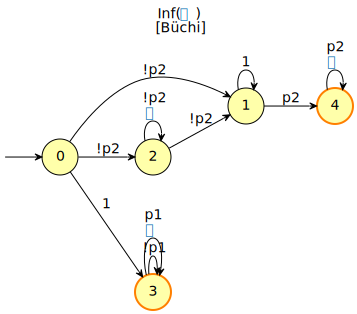

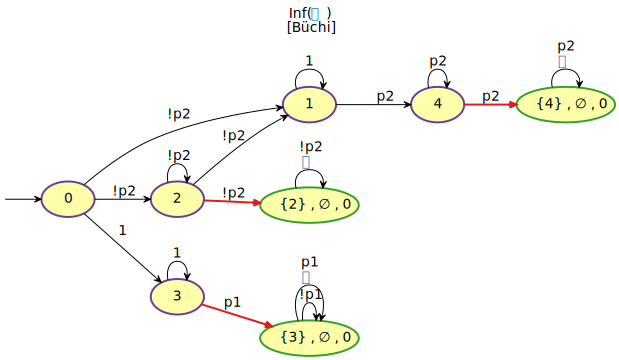

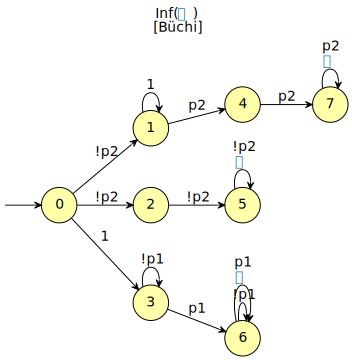

In [41]:
f = "(FGp2 R !p2) | GFp1"
in_a = spot.translate(f)
display(in_a.highlight_states([3,4],2))
seminator_form(f, '--highlight').postprocess()

## Cut-deterministic automata
The same idea can be applied to cut-deterministic automata. Removing the states 3 and 4 from the fist part of the cut-deterministic automaton would remove state $\{3\}$ and would merge the states $\{1,3,4\}$ and $\{1,3\}$.

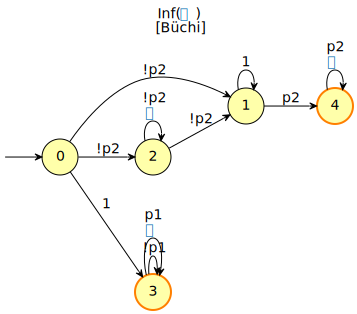

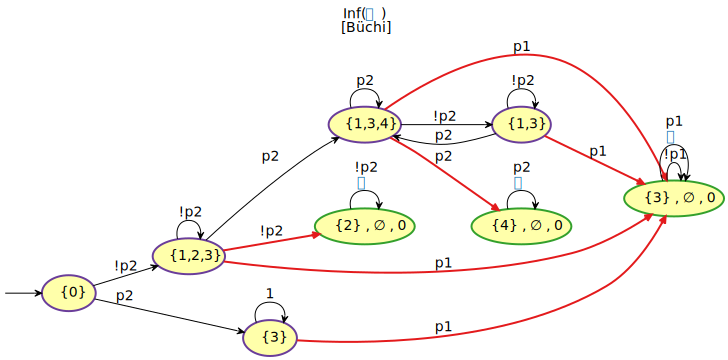

In [45]:
display(in_a)
seminator_form(f, '--highlight --cd');

## Test implementation

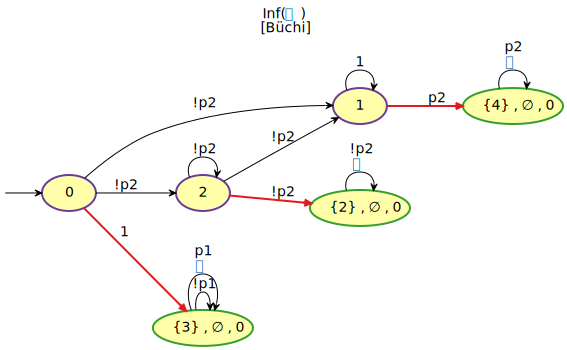

In [25]:
spot.automaton(f"ltl2tgba -f '{f}' | ~/tools/seminator/seminator --highlight --bscc-avoid -s0|")

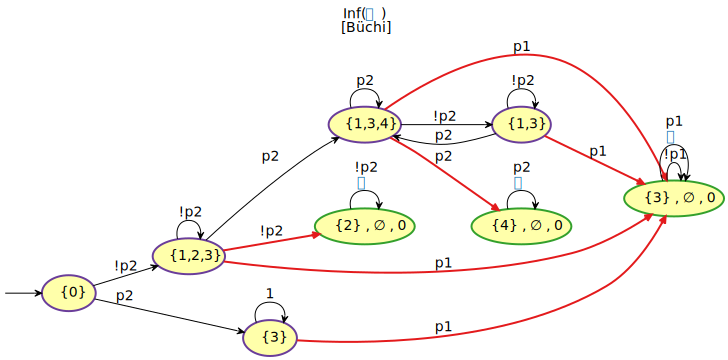

In [33]:
cd

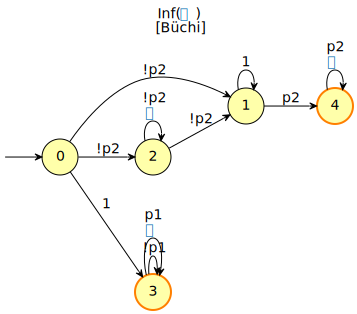

In [34]:
in_a

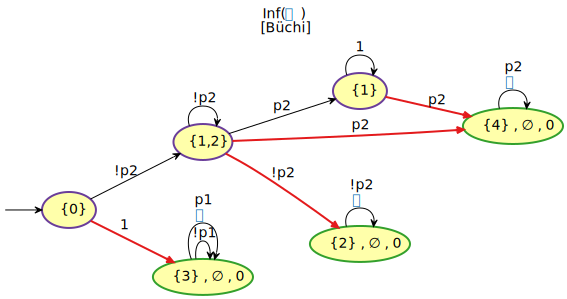

In [30]:
spot.automaton(f"ltl2tgba -f '{f}' | ~/tools/seminator/seminator --highlight --bscc-avoid --cd -s0|")

### Prepare test

In [60]:
option = 'bscc-avoid'
print(in_a.to_str(), file=open(f"{option}.hoa",'w'))
res = !{seminator_path} -s0 --{option} {option}.hoa
res_cd = !{seminator_path} -s0 --{option} --cd {option}.hoa
result = "\n".join(res)
result_cd = "\n".join(res_cd)
testfile = f"../tests/{option}.test"
test = f'''#!/bin/bash
set -e

cat >{option}.hoa <<EOF
{in_a.to_str()}
EOF

cat >{option}.expect <<EOF
{result}
EOF

cat >{option}.cd.expect <<EOF
{result_cd}
EOF


../seminator -s0 --{option} {option}.hoa > {option}.out
../seminator -s0 --{option} --cd {option}.hoa > {option}.cd.out
cat {option}.out
cat {option}.cd.out
diff {option}.out {option}.expect
diff {option}.cd.out {option}.cd.expect

rm {option}.hoa {option}.out {option}.expect {option}.cd.out {option}.cd.expect
'''

In [63]:
Add it to Makefile

SyntaxError: invalid syntax (<ipython-input-63-48db05641975>, line 1)

In [61]:
print(test,file=open(testfile,'w'))
!chmod +x {testfile}

In [62]:
!{testfile}

HOA: v1
States: 6
Start: 0
AP: 2 "p2" "p1"
acc-name: Buchi
Acceptance: 1 Inf(0)
properties: trans-labels explicit-labels trans-acc semi-deterministic
--BODY--
State: 0 "0"
[!0] 1
[!0] 2
[t] 3
State: 1 "1"
[t] 1
[0] 4
State: 2 "2"
[!0] 1
[!0] 2
[!0] 5
State: 3 "{3} , ∅ , 0"
[!1] 3
[1] 3 {0}
State: 4 "{4} , ∅ , 0"
[0] 4 {0}
State: 5 "{2} , ∅ , 0"
[!0] 5 {0}
--END--
HOA: v1
States: 6
Start: 0
AP: 2 "p2" "p1"
acc-name: Buchi
Acceptance: 1 Inf(0)
properties: trans-labels explicit-labels trans-acc semi-deterministic
--BODY--
State: 0 "{0}"
[!0] 1
[t] 3
State: 1 "{1,2}"
[!0] 1
[0] 2
[0] 4
[!0] 5
State: 2 "{1}"
[t] 2
[0] 4
State: 3 "{3} , ∅ , 0"
[!1] 3
[1] 3 {0}
State: 4 "{4} , ∅ , 0"
[0] 4 {0}
State: 5 "{2} , ∅ , 0"
[!0] 5 {0}
--END--
